# Task 2: Calculating Bias and Variance
In this question you are going to calculate the bias and variance of your trained model.

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from scipy.integrate import quad
from sklearn.neighbors import KernelDensity
import pandas as pd

In [2]:
MAX_DEGREE = 20
NUMBER_OF_PARTS = 10
model_complexity = range(1, MAX_DEGREE + 1)

## Re-sample data

In [3]:
# X_train, X_test, y_train, y_test 
train, test = None, None
with open('data/train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('data/test.pkl', 'rb') as f:
    test = pickle.load(f)
    
# randomly shuffle the data
np.random.shuffle(train)

# divide data into parts 
train_set = np.array_split(train, NUMBER_OF_PARTS)

In [4]:
def get_xy(data):
    """
    Splits data into x and y pairs
    and returns numpy array after reshaping
    """
    X, y = [], []
    for point in data:
        X.append(point[0])
        y.append(point[1])
    
    #convert to numpy array
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    
    # Reshape X and y
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    return X, y

In [5]:
bias_list = []
variance_list = []
mse_list = []

X_test, y_test = get_xy(test)

## Training and Testing

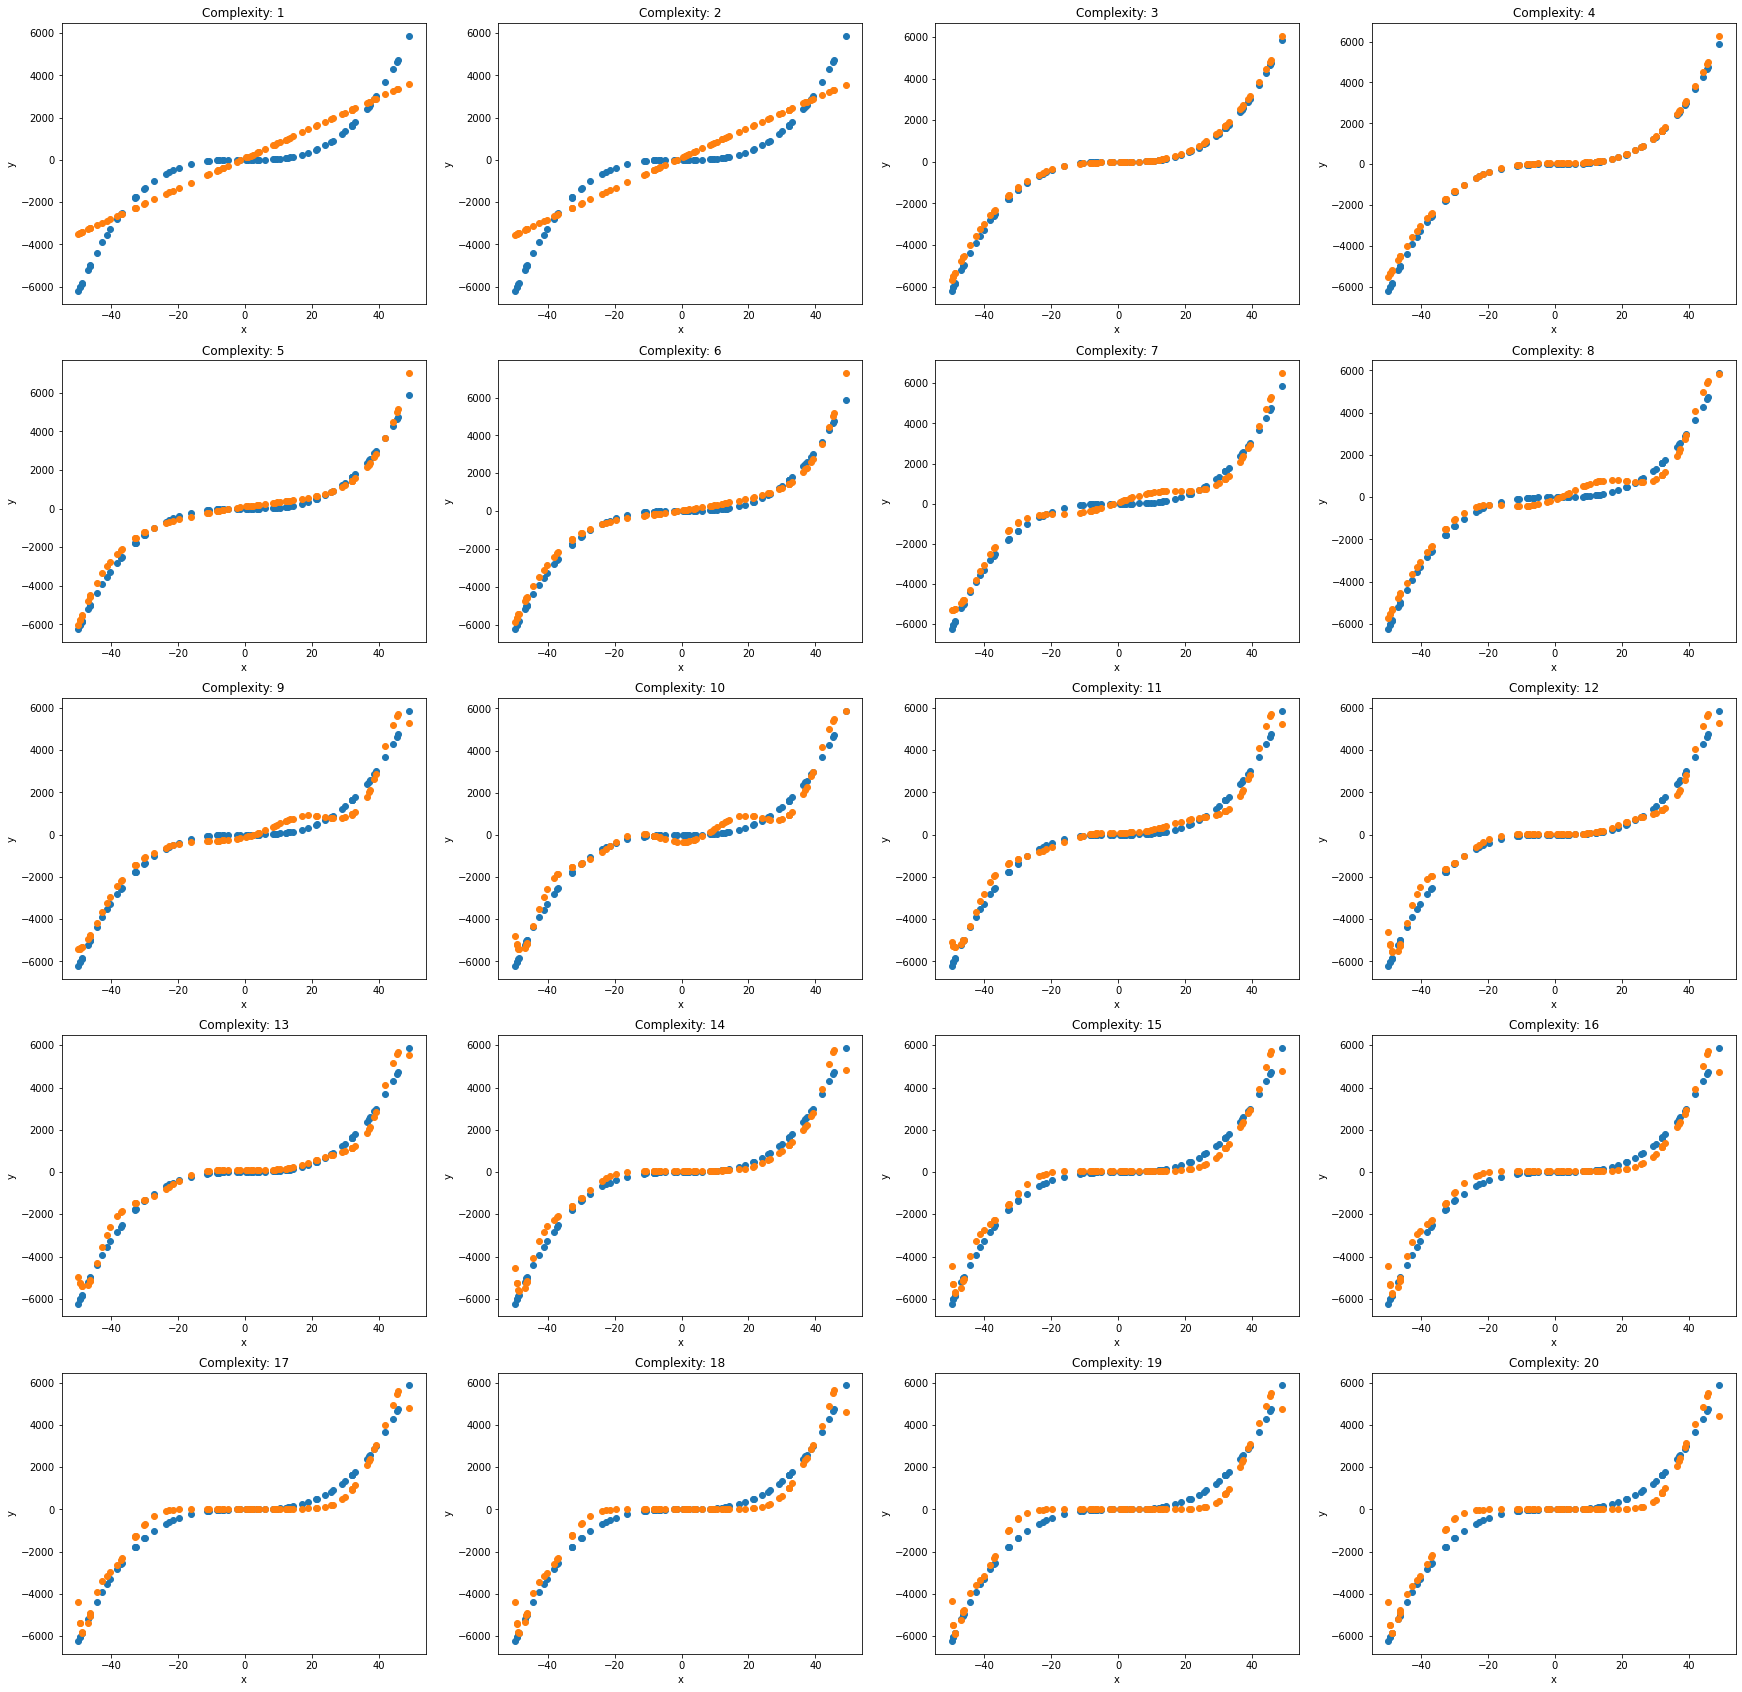

In [6]:
test_fig, test_axs = plt.subplots(5, 4, figsize=(30, 30))
train_fig, train_axs = plt.subplots(5, 4, figsize=(30, 30))
index = 0

# loop through the degrees
for deg in range(1, MAX_DEGREE + 1):
    
    predictions = []
    bias_deg_list = []
    mse_deg_list = []
    
    for part in range(0, NUMBER_OF_PARTS, 1):
        
        # get training data for  model
        X_train, y_train = get_xy(train_set[part])

        # create model and fit on data
        reg = make_pipeline(PolynomialFeatures(deg), LinearRegression()) 
        reg.fit(X_train, y_train)

        # store predictions of model
        y_pred = reg.predict(X_test)
        predictions.append(y_pred)   
        
        if part == 0:
            test_axs.flat[deg - 1].scatter(X_test, y_test, label='test data')
            test_axs.flat[deg - 1].scatter(X_test, y_pred, label='predicted data')
            test_axs.flat[deg - 1].set(xlabel='x', ylabel='y')
            test_axs.flat[deg - 1].set_title('Complexity: {}'.format(deg))
            test_handles, test_labels = test_axs.flat[deg - 1].get_legend_handles_labels()
            
            train_axs.flat[deg - 1].scatter(X_train, y_train, label='Train data')
            train_axs.flat[deg - 1].scatter(X_train, reg.predict(X_train), label='predicted data')
            train_axs.flat[deg - 1].set(xlabel='x', ylabel='y')
            train_axs.flat[deg - 1].set_title('Complexity: {}'.format(deg))
            train_handles, train_labels = train_axs.flat[deg - 1].get_legend_handles_labels()
    
    

    # f'^2
    predictions_2 = np.multiply(predictions, predictions)
    # E[f'^2]
    E_predictions2 = np.mean(predictions_2, 0)
    # E[f']
    E_predictions = np.mean(predictions, 0)
    
    bias = abs(np.mean(np.subtract(E_predictions, y_test)))
    bias_list.append(bias)
    
        
    mse = mean_squared_error(y_test, E_predictions)  
    mse_list.append(mse)
    
    variance = np.mean(E_predictions2 - np.multiply(E_predictions, E_predictions))
    variance_list.append(variance)

plt.close()

## Calculating Irreducible Error

In [7]:
bias_list = np.asarray(bias_list, dtype=np.float64)
variance_list = np.asarray(variance_list, dtype=np.float64)
irreducible_error_list = np.subtract(mse_list, np.add(np.multiply(bias_list, bias_list), variance_list))
df = pd.DataFrame({
    'Mse': mse_list, 
    'Bias': bias_list, 
    'Variance': variance_list, 
    'Irreducible Error': irreducible_error_list
    })
df.index = np.arange(1, len(df) + 1)
df

,Mse,Bias,Variance,Irreducible Error
1,1.002800e+06,232.005323,35492.791744,913481.199591
2,9.510221e+05,226.032773,69343.520506,830587.769535
3,9.508492e+03,14.919166,69939.200812,-60653.289965
4,9.121607e+03,10.766487,83881.706613,-74876.017049
5,7.956685e+03,6.884769,99800.853149,-91891.567867
6,8.250149e+03,4.125681,134443.234248,-126210.106855
7,9.848982e+03,0.649577,152100.005687,-142251.445729
8,9.726136e+03,1.546336,161373.286059,-151649.541493
9,9.438626e+03,0.726994,173985.830272,-164547.733241
10,1.242304e+04,7.086025,186306.442688,-173933.618037


## Plotting Bias<sup>2</sup> - Variance tradeoff

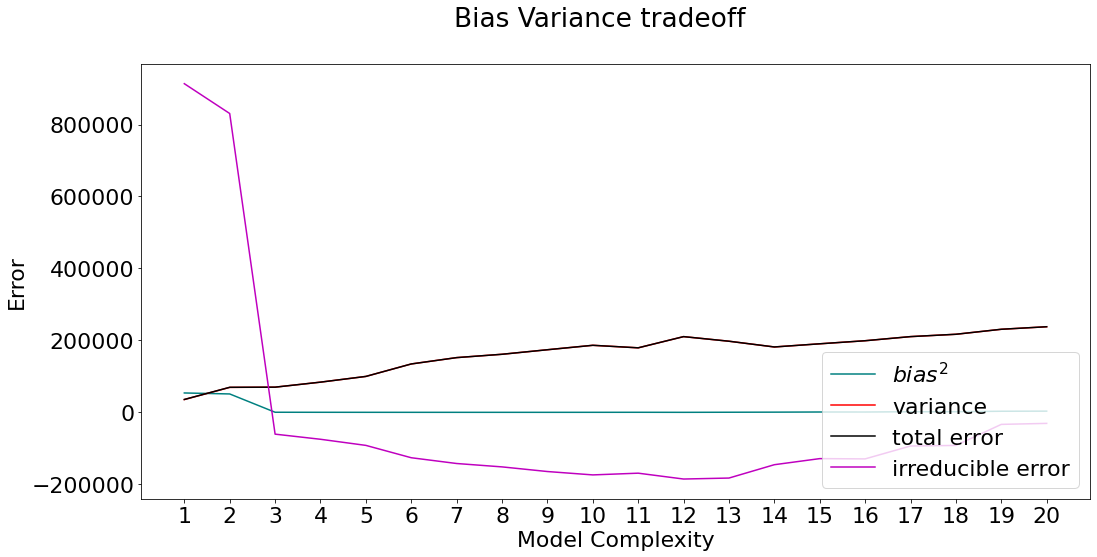

In [9]:
fig = plt.figure(figsize=(17, 8))

plt.rcParams.update({'font.size': 22})
plt.plot(model_complexity, np.multiply(bias_list, bias_list), c="teal", label="$bias^2$")    
plt.plot(model_complexity, variance_list, c="r", label="variance")    
plt.plot(model_complexity, bias_list + variance_list, c="k", label="total error")
plt.plot(model_complexity,  irreducible_error_list, c="m", label="irreducible error")
fig.suptitle('Bias Variance tradeoff')
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.legend(loc='lower right')
_ = plt.xticks(model_complexity)

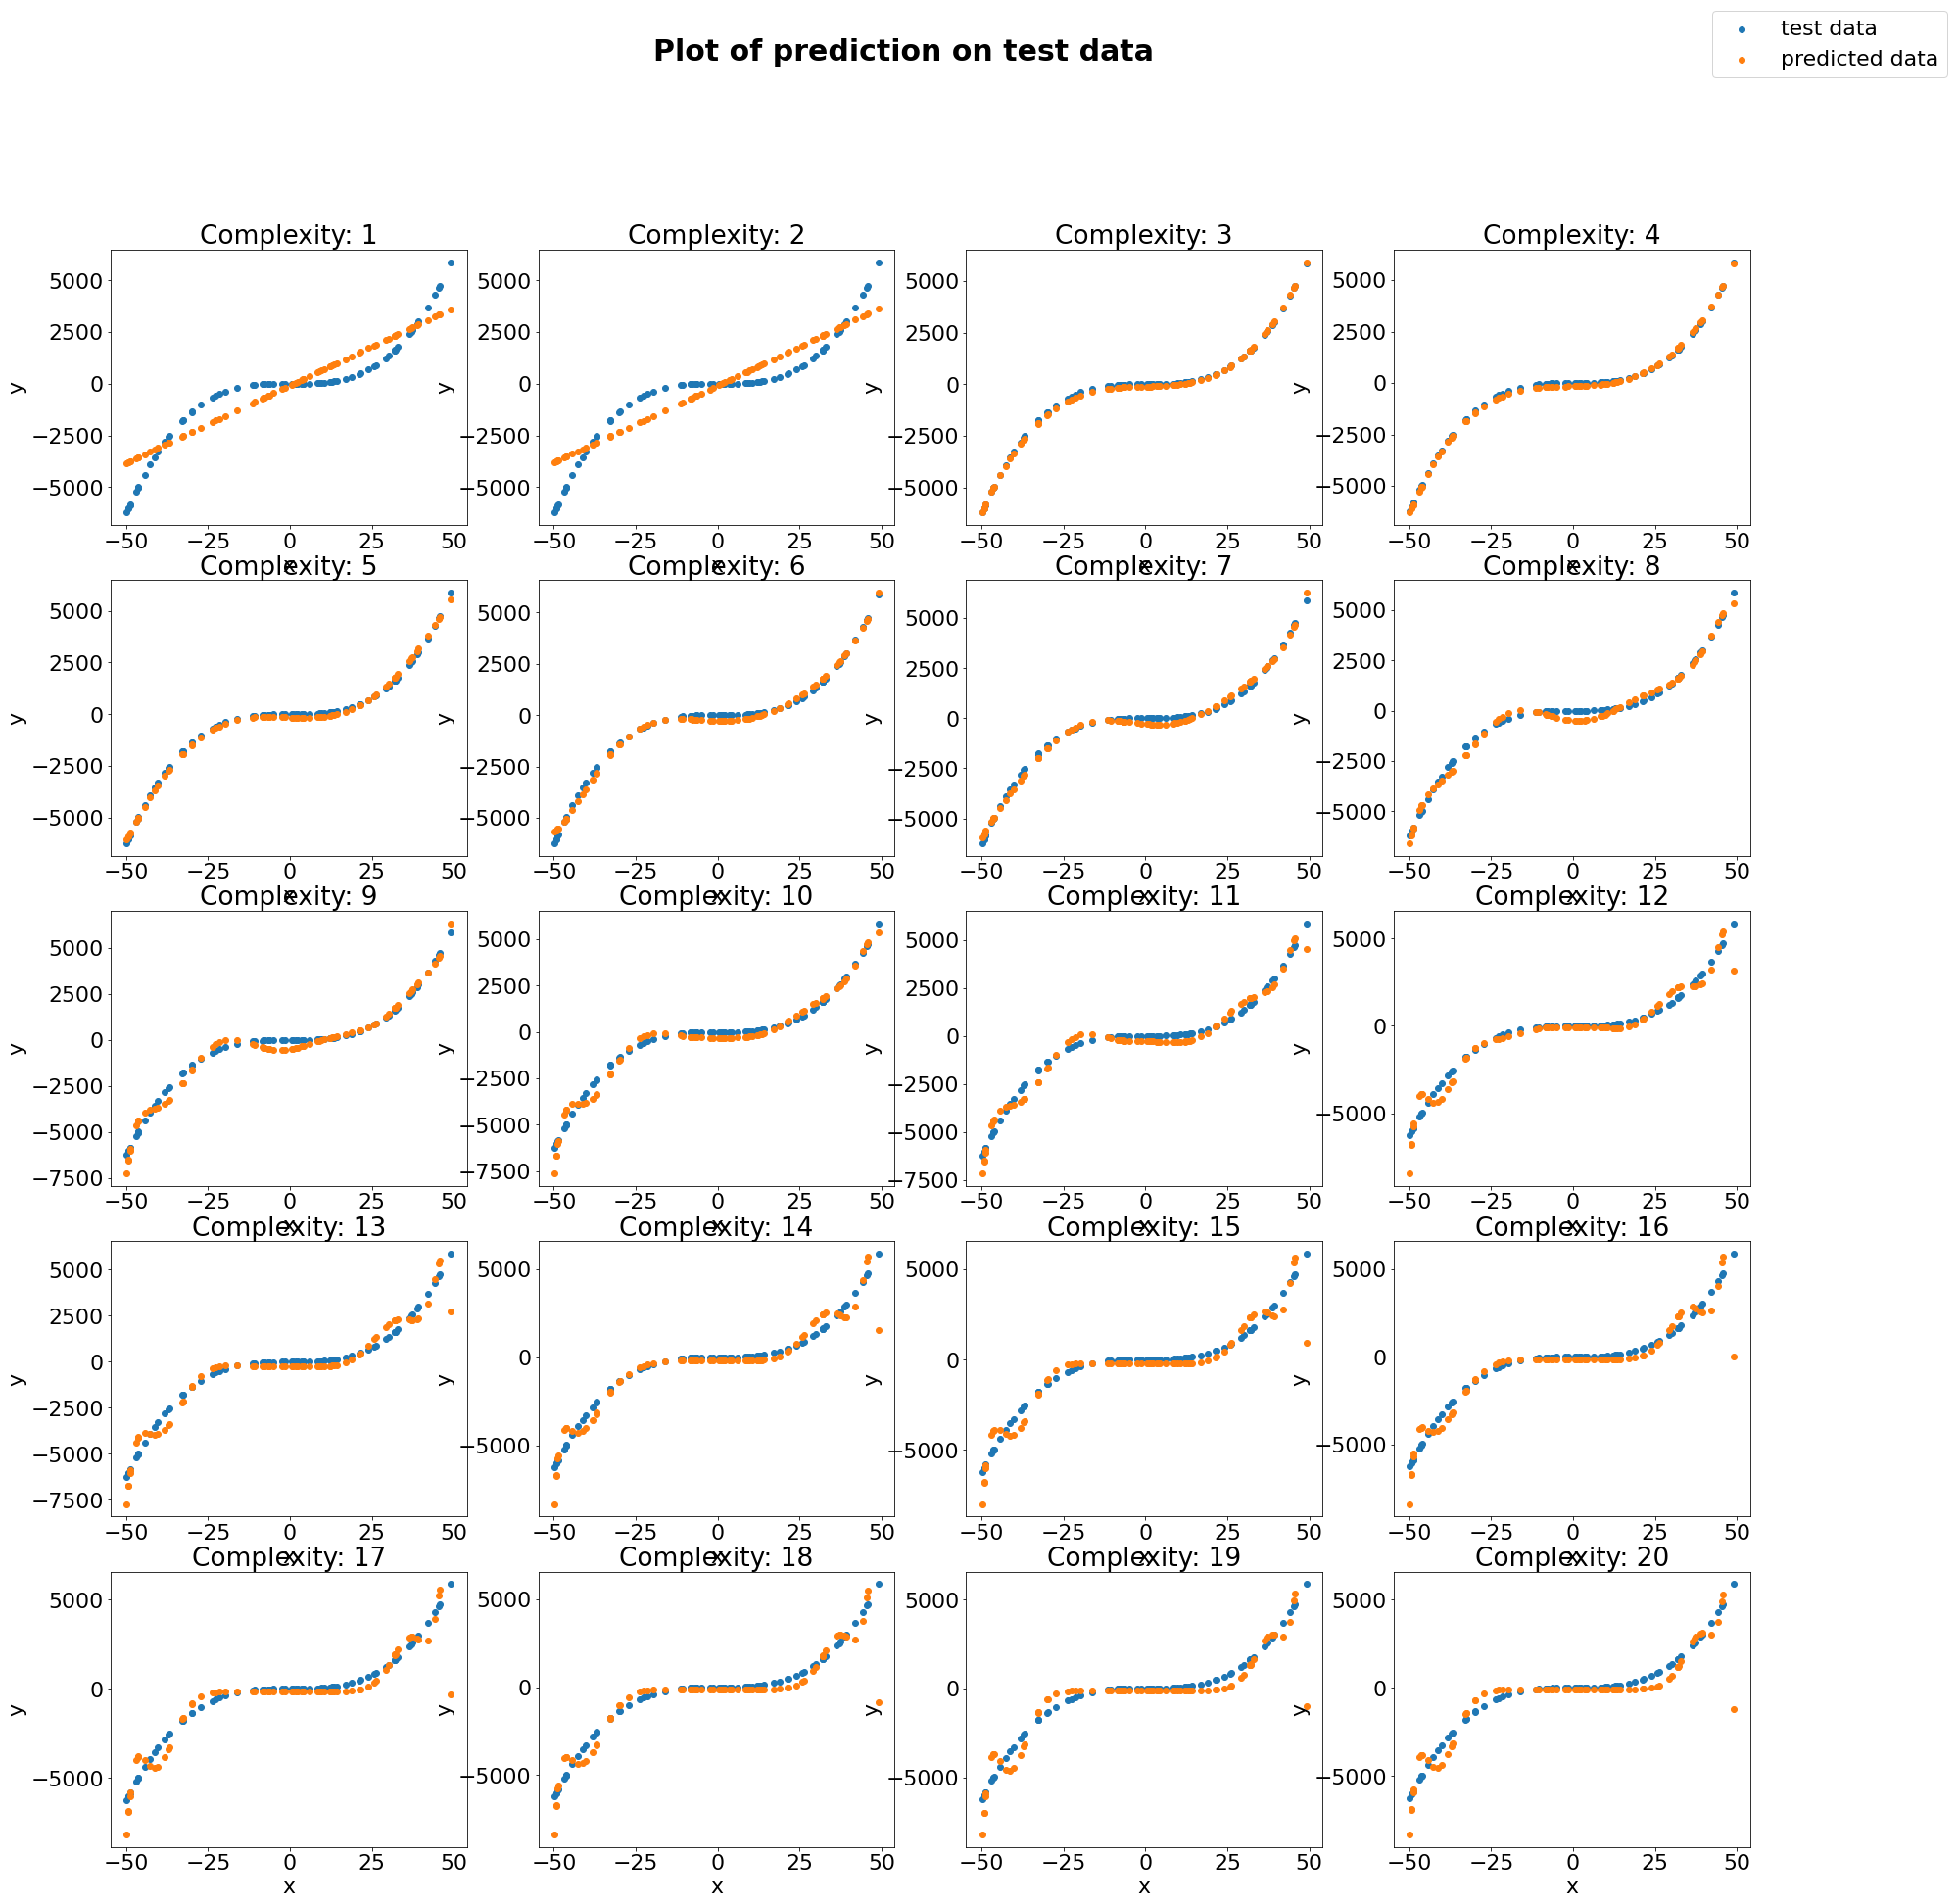

In [36]:
test_fig.legend(test_handles, test_labels, loc='upper right', fontsize=22)
test_fig.suptitle('Plot of prediction on test data', fontweight='bold', size=30)
test_fig

Text(0, 0.5, 'MSE')

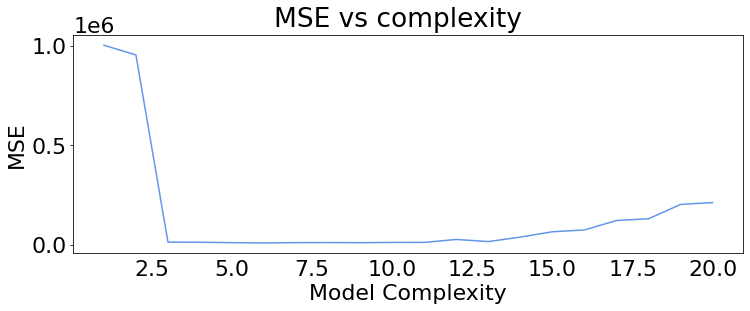

In [30]:
fig = plt.figure(figsize=(12, 4))

plt.rcParams.update({'font.size': 22})
plt.tick_params(axis='x', bottom=False)
plt.plot(model_complexity, mse_list, color="cornflowerblue")    
fig.suptitle('MSE vs complexity')
plt.xlabel('Model Complexity')
plt.ylabel('MSE')

Text(0, 0.5, 'Bias')

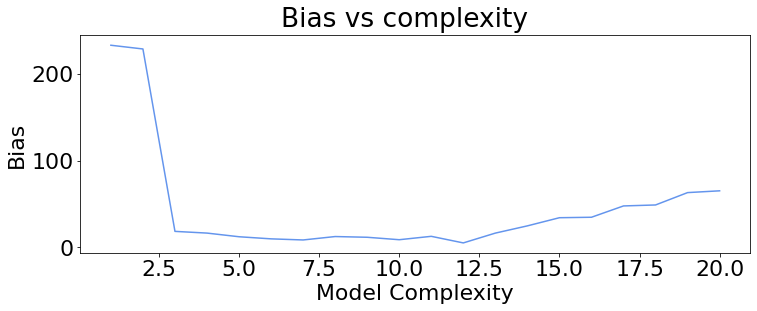

In [23]:
fig = plt.figure(figsize=(12, 4))

plt.rcParams.update({'font.size': 22})
plt.plot(model_complexity, bias_list, color="cornflowerblue")    
fig.suptitle('Bias vs complexity')
plt.xlabel('Model Complexity')
plt.ylabel('Bias')

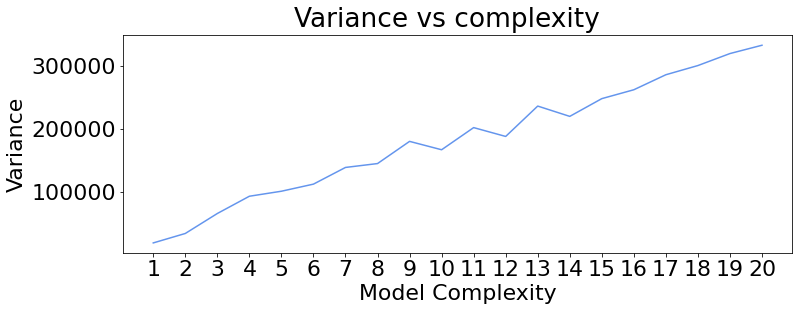

In [31]:
fig = plt.figure(figsize=(12, 4))

plt.rcParams.update({'font.size': 22})
plt.plot(model_complexity, variance_list, color="cornflowerblue")    
fig.suptitle('Variance vs complexity')
plt.xlabel('Model Complexity')
plt.ylabel('Variance')
_ = plt.xticks(model_complexity)

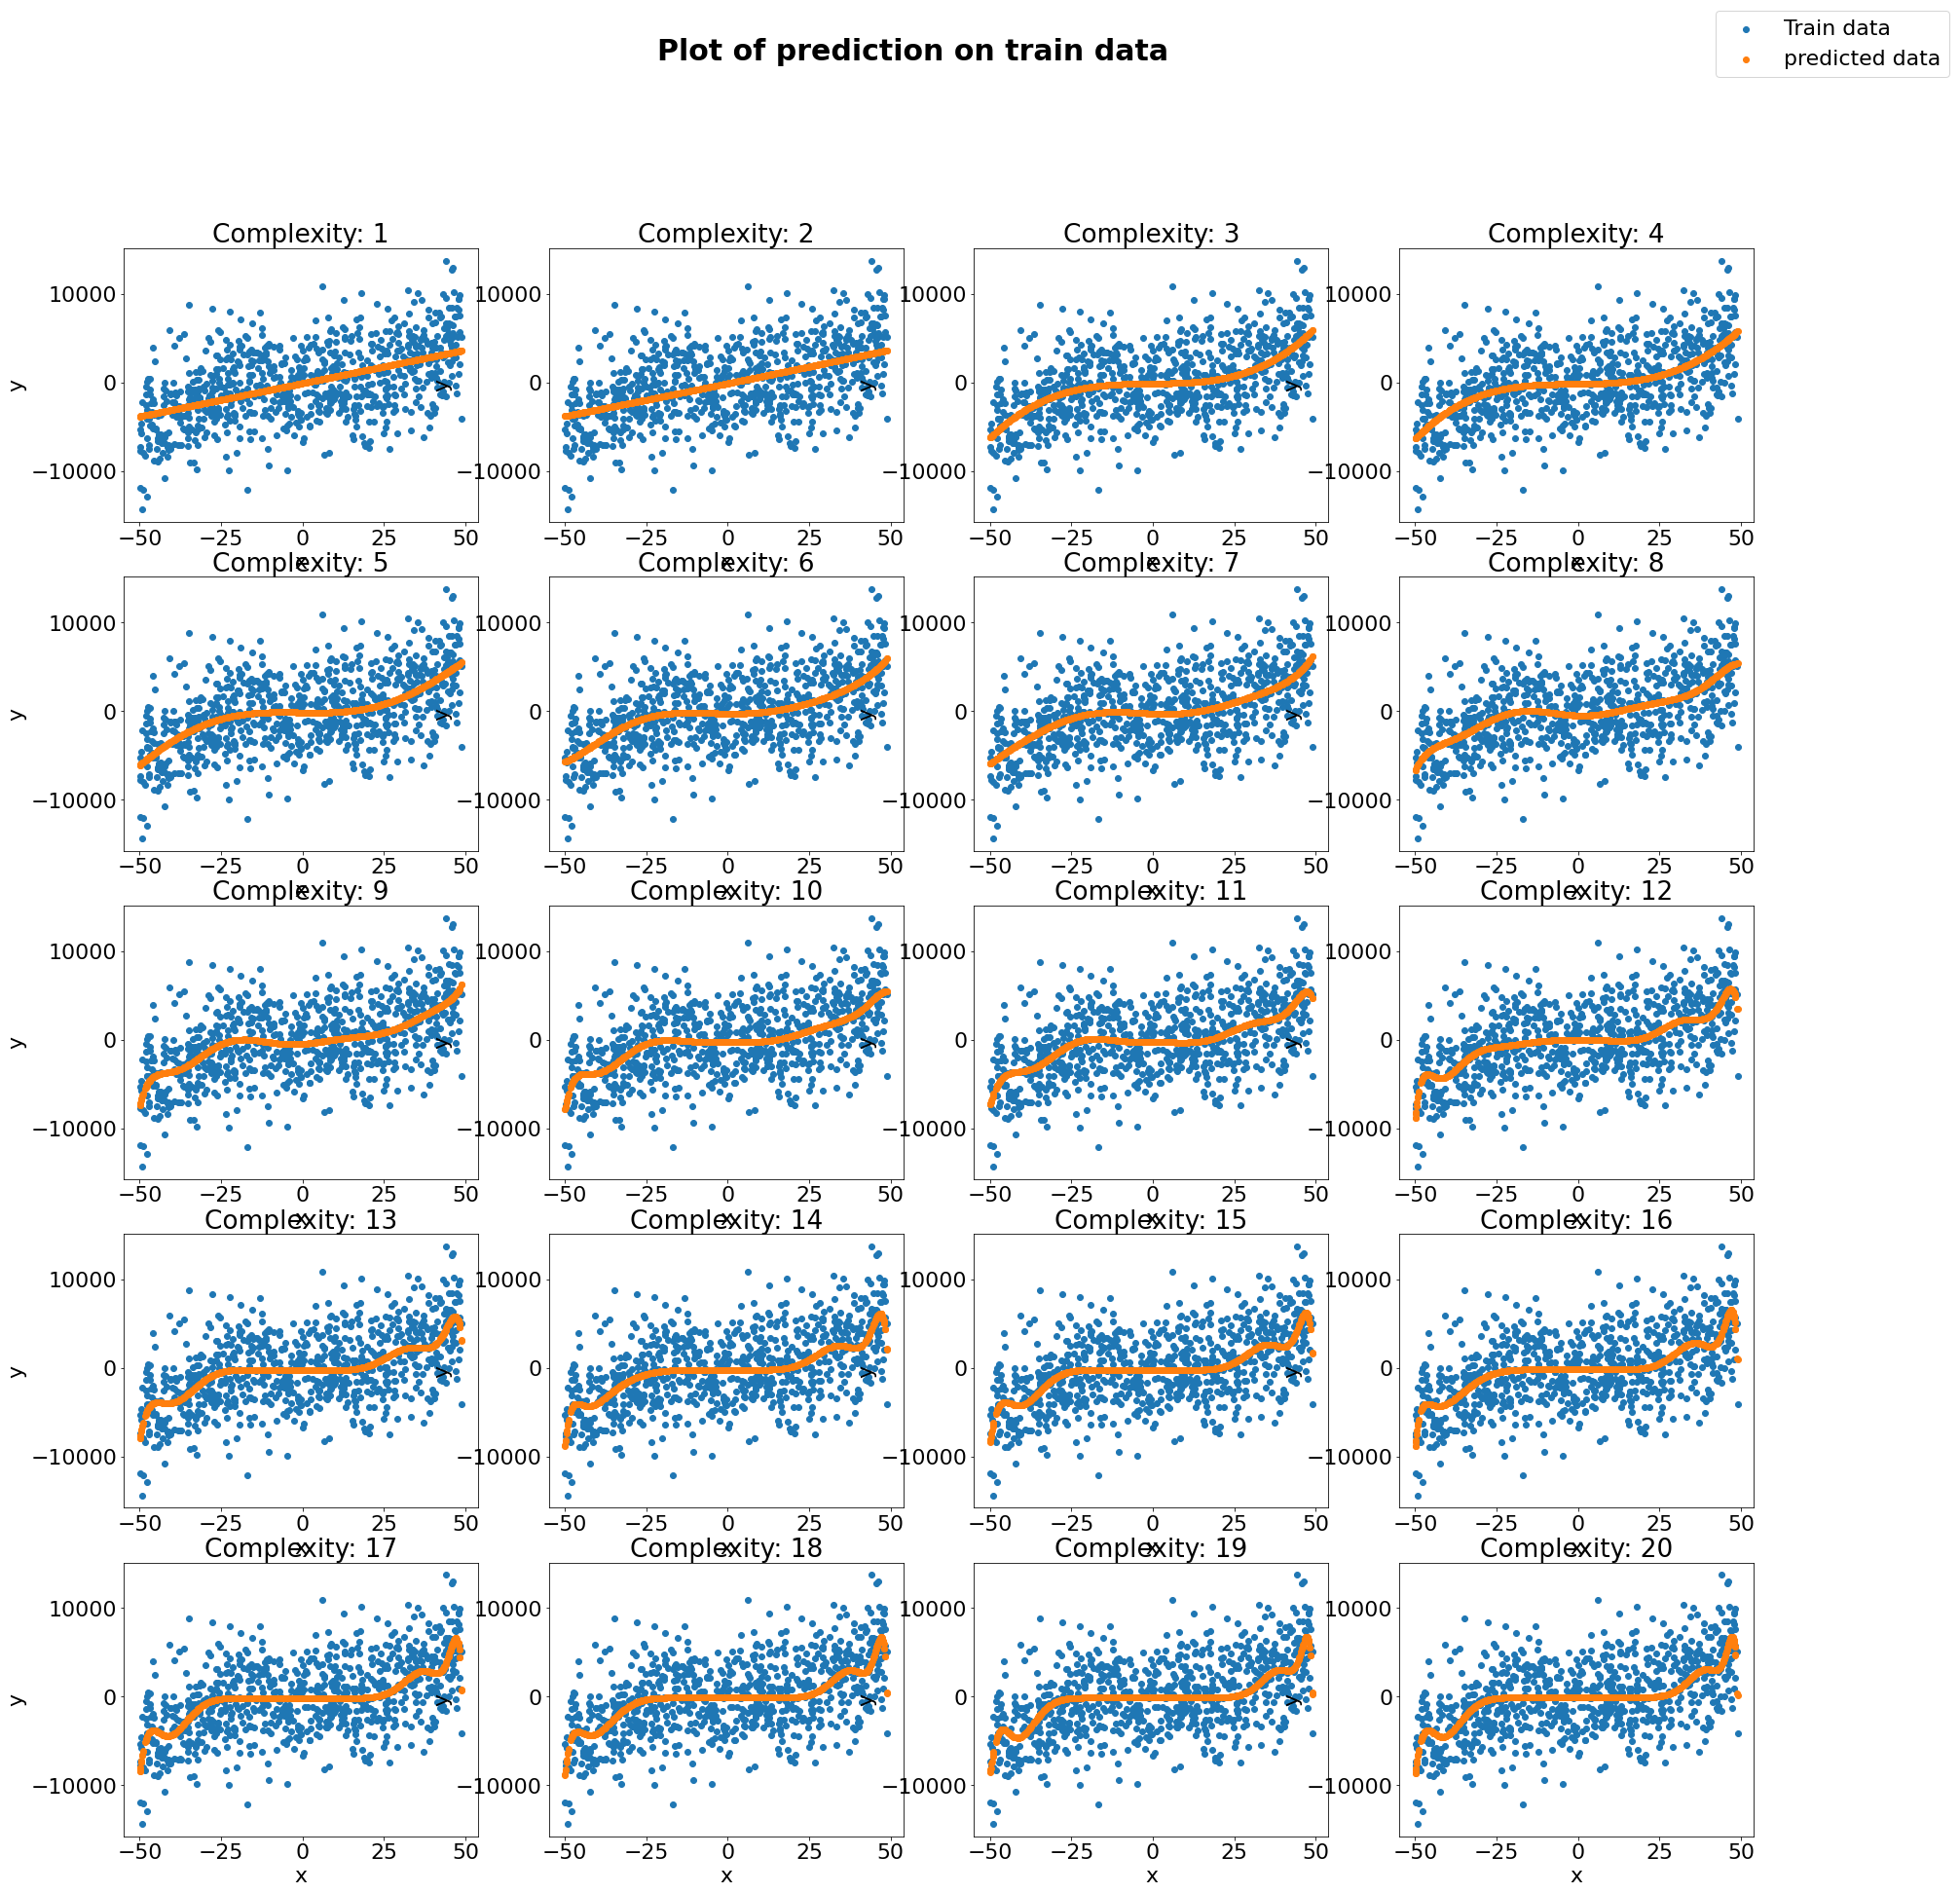

In [37]:
train_fig.legend(train_handles, train_labels, loc='upper right', fontsize=22)
train_fig.suptitle('Plot of prediction on train data', fontweight='bold', size=30)
train_fig